# Multi-label Amazon From Space

In [ ]:
#@title

! pip -qq install tensorflow-addons

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 686kB 33.5MB/s 
Mounted at /content/drive


In [ ]:
import tensorflow as tf

class Config:
  class data:
    path = '/root/tensorflow_datasets/amazon-from-space'
    size = (256, 256)
    shape = (*size, 3)
    batch_size = 64
    shuffle_buffer_size = 8 * batch_size
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE
    train_shuffle_seed = 2142
    shuffle = True

    preprocess = tf.keras.applications.resnet_v2.preprocess_input
    deprocess = lambda x: tf.cast(tf.clip_by_value((x+1)*127.5, 0, 255), tf.uint8)

  class aug:
    brightness_delta =  .2
    saturation_lower =  .2
    saturation_upper = 1.0
    contrast_lower   =  .5
    contrast_upper   = 1.5
    hue_delta        =  .0
    
  class model:
    pool_layer = 'avg_pool'
    backbone = tf.keras.applications.ResNet101V2

    ae_latent_dim = 128
    ae_intermediate_dim = 512
  
  class training:
    epochs = 80
    learning_rate = 1.
    lr_first_decay_steps = 50

    fine_tune_lr = .02
    fine_tune_epochs = 80
    fine_tune_layers = .6  # 60%
    freeze_batch_norm = False

    valid_size = 0.3

    fine_tune_early_reduce_lr_patience = 5
    fine_tune_early_stopping_patience = 20

  class experiment:
    seed = 218402
    override = True
    logs              = '/content/drive/MyDrive/logs/amazon-from-space/resnet101-ce/'
    fine_tune_logs    = '/content/drive/MyDrive/logs/amazon-from-space/resnet101-ce-fine-tune/'

    training_weights  = '/content/drive/MyDrive/logs/amazon-from-space/resnet101-ce/weights.h5'
    fine_tune_weights = '/content/drive/MyDrive/logs/amazon-from-space/resnet101-ce-fine-tune/weights.h5'

## Setup

In [ ]:
import os
import shutil
from math import ceil

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import callbacks

In [ ]:
for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.


In [ ]:
R = tf.random.Generator.from_seed(Config.experiment.seed, alg='philox')
C = np.asarray(sns.color_palette("Set1", 21))
CMAP = sns.color_palette("Set1", 21, as_cmap=True)

sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
def normalize(x, reduce_min=True, reduce_max=True):
  if reduce_min: x -= tf.reduce_min(x, axis=(-3, -2), keepdims=True)
  if reduce_max: x = tf.math.divide_no_nan(x, tf.reduce_max(x, axis=(-3, -2), keepdims=True))

  return x


def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    figsize=(16, 7.2),
    cmap=None
):
  if image is not None:
    if isinstance(image, (list, tuple)) or len(image.shape) > 3:  # many images
      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

## Dataset

### Augmentation Policy

In [ ]:
def default_policy_fn(image):
  # image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # mask = tf.image.resize_with_crop_or_pad(mask, *Config.data.size)

  return image


def augment_policy_fn(image):
  seeds = R.make_seeds(6)

  # image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # image = tf.image.stateless_random_crop(image, [*Config.data.size, 3], seed=seeds[:, 0])
  # mask = tf.image.stateless_random_crop(mask, [*Config.data.size, 1], seed=seeds[:, 0])

  image = tf.image.stateless_random_flip_left_right(image, seed=seeds[:, 0])
  # mask = tf.image.stateless_random_flip_left_right(mask, seed=seeds[:, 0])
  
  image = tf.image.stateless_random_flip_up_down(image, seed=seeds[:, 1])
  # mask = tf.image.stateless_random_flip_up_down(mask, seed=seeds[:, 1])

  image = tf.image.stateless_random_hue(image, Config.aug.hue_delta, seed=seeds[:, 2])
  image = tf.image.stateless_random_brightness(image, Config.aug.brightness_delta, seed=seeds[:, 3])
  image = tf.image.stateless_random_contrast(image, Config.aug.contrast_lower, Config.aug.contrast_upper, seed=seeds[:, 4])
  image = tf.image.stateless_random_saturation(image, Config.aug.saturation_lower, Config.aug.saturation_upper, seed=seeds[:, 5])

  return image

### Preparing and Performance Settings

In [ ]:
data_path = Config.data.path

In [ ]:
%%bash

if [ ! -d /root/tensorflow_datasets/amazon-from-space/ ]; then
  mkdir -p /root/tensorflow_datasets/amazon-from-space/

  # gdown --id 12wCmah0FFPIjI78YJ2g_YWFy97gaA5S9 --output /root/tensorflow_datasets/amazon-from-space/train-jpg.tfrecords

  cp /content/drive/MyDrive/datasets/amazon-from-space/train-jpg.tfrecords \
     /root/tensorflow_datasets/amazon-from-space/
else
  echo "Dir $data_path found. Skipping."
fi

In [ ]:
# ! gdown --id 12wCmah0FFPIjI78YJ2g_YWFy97gaA5S9 --output /root/tensorflow_datasets/amazon-from-space/train-jpg.tfrecords

In [ ]:
class AmazonFromSpace:
    num_train_samples = 40479
    num_test_samples  = 61191

    classes_ = np.asarray(
        ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down',
         'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze',
         'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water'])

    @classmethod
    def int2str(cls, indices):
        return cls.classes_[indices]
    
    @staticmethod
    def _bytes_feature(value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.tobytes()]))

    @staticmethod
    def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
    @staticmethod
    def decode_fn(record_bytes):
        r = tf.io.parse_single_example(record_bytes, {
          'filename': tf.io.FixedLenFeature([], tf.string),
          'image': tf.io.FixedLenFeature([], tf.string),
          'height': tf.io.FixedLenFeature([], tf.int64, default_value=[256]),
          'width': tf.io.FixedLenFeature([], tf.int64, default_value=[256]),
          'channels': tf.io.FixedLenFeature([], tf.int64, default_value=[3]),
          'label': tf.io.VarLenFeature(tf.int64),
        })
        
        r['image'] = tf.reshape(tf.io.decode_raw(r['image'], tf.uint8),
                                (r['height'], r['width'], r['channels']))
        r['label'] = tf.sparse.to_dense(r['label'])

        return r
    
    @classmethod
    def load(cls, tfrecords_path):
        return tf.data.TFRecordDataset(tfrecords_path).map(cls.decode_fn, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
CLASSES = AmazonFromSpace.classes_
int2str = AmazonFromSpace.int2str
num_samples = AmazonFromSpace.num_train_samples
num_train_samples = int((1-Config.training.valid_size)*num_samples)
num_valid_samples = int(Config.training.valid_size*num_samples)

In [ ]:
from functools import partial


@tf.function
def load_fn(d, augment=False):
  image = d['image']
  labels = d['label']

  image = tf.cast(image, tf.float32)
  image = tf.ensure_shape(image, Config.data.shape)

  # image, _ = adjust_resolution(image)
  image = (augment_policy_fn(image)
           if augment
           else default_policy_fn(image))
  
  image = Config.data.preprocess(image)

  return image, labels_to_one_hot(labels)


def adjust_resolution(image):
  es = tf.constant(Config.data.size, tf.float32)
  xs = tf.cast(tf.shape(image)[:2], tf.float32)

  ratio = tf.reduce_min(es / xs)
  xsn = tf.cast(tf.math.ceil(ratio * xs), tf.int32)

  image = tf.image.resize(image, xsn, preserve_aspect_ratio=True, method='nearest')

  return image, ratio


def labels_to_one_hot(labels):
  return tf.reduce_max(
      tf.one_hot(labels, depth=CLASSES.shape[0]),
    axis=0)


def prepare(ds, batch_size, cache=False, shuffle=False, augment=False):
  if cache: ds = ds.cache()
  if shuffle: ds = ds.shuffle(Config.data.shuffle_buffer_size, reshuffle_each_iteration=True, seed=Config.data.train_shuffle_seed)

  return (ds.map(partial(load_fn, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size, drop_remainder=True)
            .prefetch(Config.data.prefetch_buffer_size))

In [ ]:
train_dataset = AmazonFromSpace.load('/root/tensorflow_datasets/amazon-from-space/train-jpg.tfrecords')
valid_dataset = train_dataset.take(num_valid_samples)
train_dataset = train_dataset.skip(num_valid_samples)

train = prepare(train_dataset, Config.data.batch_size, shuffle=True, augment=True)
valid = prepare(valid_dataset, Config.data.batch_size)

### Examples in The Dataset

In [ ]:
#@title

for stage, batches, samples in zip(('training', 'validation', 'testing'),
                                   (train, valid),
                                   (AmazonFromSpace.num_train_samples,
                                    num_valid_samples,
                                    AmazonFromSpace.num_test_samples)):
  print(stage)
  print(f'  {batches}')
  print(f'  samples: {samples}')
  print(f'  steps  : {samples // Config.data.batch_size}')
  print()

training
  <PrefetchDataset shapes: ((64, 256, 256, 3), (64, 17)), types: (tf.float32, tf.float32)>
  samples: 40479
  steps  : 632

validation
  <PrefetchDataset shapes: ((64, 256, 256, 3), (64, 17)), types: (tf.float32, tf.float32)>
  samples: 12143
  steps  : 189



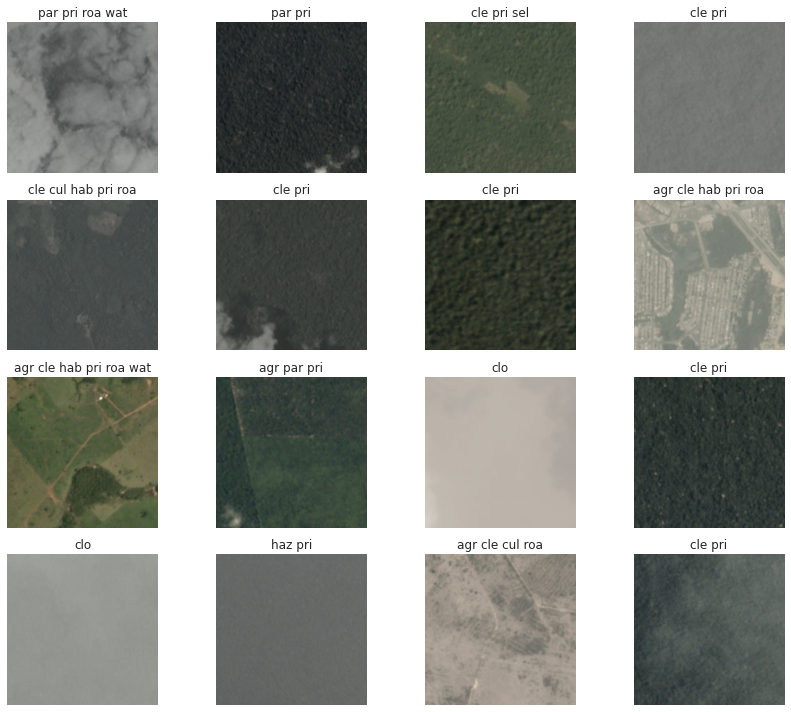

In [ ]:
#@title

for images, labels in train.take(1):
  gt = [' '.join((e[:3] for e in CLASSES[l].astype(str))) for l in labels.numpy().astype(bool)]
  visualize(Config.data.deprocess(images[:16]), gt, rows=4, figsize=(12, 10));

## Network

In [ ]:
print(f'Loading {Config.model.backbone.__name__}')

backbone = Config.model.backbone(
  classifier_activation=None,
  include_top=False,
  input_shape=Config.data.shape
)
backbone.trainable = False

Loading ResNet101V2
171319296/171317808 [==============================] - 1s 0us/step


### Softmax weights

Dense With Softmax Weights Layer:

\begin{align}
l_c &= X \cdot [W \circ \text{softmax}_c(W - max_c(W))] + b\\
y_c &= \sigma(l)_c
\end{align}

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout


class DenseKur(Dense):
  """Dense with Softmax Weights.
  """
  def call(self, inputs):
    kernel = self.kernel
    ag = kernel  # ag = tf.abs(kernel)
    ag = ag - tf.reduce_max(ag, axis=-1, keepdims=True)
    ag = tf.nn.softmax(ag)

    outputs = inputs @ (ag * kernel)

    if self.use_bias:
      outputs = tf.nn.bias_add(outputs, self.bias)

    if self.activation is not None:
      outputs = self.activation(outputs)

    return outputs

### Classification Head

In [ ]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Dense


def build_classifier():
  x = tf.keras.Input(Config.data.shape, name='images')
  y = backbone(x)
  y = GlobalAveragePooling2D(name=Config.model.pool_layer)(y)
  y = Dense(len(CLASSES), name='predictions')(y)
  # y = DenseKur(len(CLASSES), name='predictions')(y)

  # kernel_regularizer = tf.regularizers.L2(1e-4)
  # bias_regularizer = tf.regularizers.L2(1e-4)

  return tf.keras.Model(
    inputs=x,
    outputs=y,
    name=f'clf_{Config.model.backbone.__name__}_voc12')

In [ ]:
nn = build_classifier()

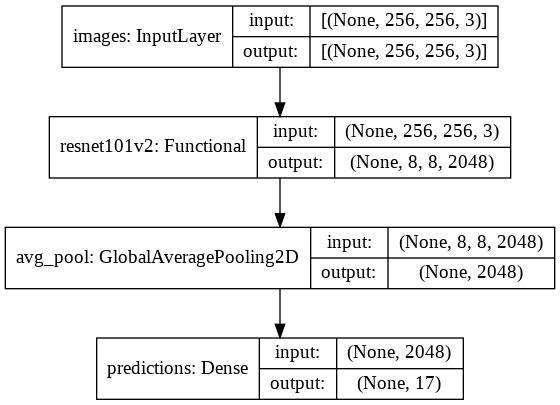

In [ ]:
tf.keras.utils.plot_model(nn, show_shapes=True)

## Metrics

In [ ]:
class FromLogitsMixin:
  def __init__(self, from_logits=False, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.from_logits = from_logits

  def update_state(self, y_true, y_pred, sample_weight=None):
    if self.from_logits:
      y_pred = tf.nn.sigmoid(y_pred)
    return super().update_state(y_true, y_pred, sample_weight)


class AUC(FromLogitsMixin, tf.metrics.AUC):
  ...

class BinaryAccuracy(FromLogitsMixin, tf.metrics.BinaryAccuracy):
  ...

class TruePositives(FromLogitsMixin, tf.metrics.TruePositives):
  ...

class FalsePositives(FromLogitsMixin, tf.metrics.FalsePositives):
  ...

class TrueNegatives(FromLogitsMixin, tf.metrics.TrueNegatives):
  ...

class FalseNegatives(FromLogitsMixin, tf.metrics.FalseNegatives):
  ...

class Precision(FromLogitsMixin, tf.metrics.Precision):
  ...

class Recall(FromLogitsMixin, tf.metrics.Recall):
  ...

class F1Score(FromLogitsMixin, tfa.metrics.F1Score):
  ...

## Training

### Top Classifier Training

In [ ]:
# lr_schedule = tf.optimizers.schedules.ExponentialDecay(1e-4, 100, 0.9)
# wd_schedule = tf.optimizers.schedules.ExponentialDecay(5e-5, 100, 0.9)

# opt = tfa.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=lambda : None)
# opt.weight_decay = lambda : wd_schedule(opt.iterations)

nn.compile(
    optimizer=tf.optimizers.SGD(learning_rate=Config.training.learning_rate, momentum=0.9, nesterov=True),
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
      F1Score(num_classes=len(CLASSES), from_logits=True, average='macro'),
      Precision(from_logits=True),
      Recall(from_logits=True),
      # AUC(from_logits=True),
      # BinaryAccuracy(from_logits=True),
      # TruePositives(from_logits=True),
      # FalsePositives(from_logits=True),
      # TrueNegatives(from_logits=True),
      # FalseNegatives(from_logits=True),
    ])

In [ ]:
resuming = False
initial_epoch = 0

if resuming:
  nn.load_weights(Config.experiment.training_weights)

In [ ]:
try:
  nn.fit(
    train.repeat(),
    validation_data=valid.repeat(),
    epochs=Config.training.epochs,
    steps_per_epoch=num_train_samples // Config.data.batch_size,
    validation_steps=num_valid_samples // Config.data.batch_size,
    initial_epoch=initial_epoch,
    callbacks=[
      callbacks.TerminateOnNaN(),
      callbacks.ModelCheckpoint(
        Config.experiment.training_weights,
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
      callbacks.TensorBoard(
        Config.experiment.logs,
        histogram_freq=1,
        write_graph=True,
        profile_batch=0,
      ),
      callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=5,
        min_lr=0.0001,
        verbose=1
      ),
      callbacks.EarlyStopping(
        min_delta=0.05,
        patience=20,
        verbose=1
      )
    ]);

except KeyboardInterrupt: print('\ninterrupted')
else: print('\ndone')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


Epoch 9/80
442/442 [==============================] - 271s 608ms/step - loss: 0.1438 - f1_score: 0.1491 - precision: 0.8920 - recall: 0.7719 - val_loss: 0.1391 - val_f1_score: 0.1415 - val_precision: 0.8819 - val_recall: 0.7911

Epoch 00009: val_loss improved from inf to 0.13906, saving model to /content/drive/MyDrive/logs/amazon-from-space/resnet101-sw-ce/weights.h5
Epoch 10/80
442/442 [==============================] - 291s 647ms/step - loss: 0.1368 - f1_score: 0.1592 - precision: 0.8946 - recall: 0.7843 - val_loss: 0.1338 - val_f1_score: 0.1548 - val_precision: 0.8917 - val_recall: 0.7944

Epoch 00010: val_loss improved from 0.13906 to 0.13382, saving model to /content/drive/MyDrive/logs/amazon-from-space/resnet101-sw-ce/weights.h5
Epoch 11/80
442/442 [==============================] - 291s 644ms/step - loss: 0.1332 - f1_score: 0.1626 - precision: 0.8964 - recall: 0.7902 - val_loss: 0.1312 - val_f1_score: 0.1582 - val_precision: 0.8883 - val_recall: 0.8047

Epoch 00011: val_loss imp

### Fine-Tuning

In [ ]:
trained_epochs = 26

nn.load_weights(Config.experiment.training_weights)

In [ ]:
if Config.training.fine_tune_epochs:
  backbone.trainable = True

  frozen_layer_ix = int((1-Config.training.fine_tune_layers) * len(backbone.layers))
  for ix, l in enumerate(backbone.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not Config.training.freeze_batch_norm))

  nn.compile(
    optimizer=tf.optimizers.SGD(learning_rate=Config.training.fine_tune_lr,
                                momentum=0.9,
                                nesterov=True),
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
      F1Score(num_classes=len(CLASSES), from_logits=True, average='macro'),
      Precision(from_logits=True),
      Recall(from_logits=True),
      # AUC(from_logits=True),
      # BinaryAccuracy(from_logits=True),
      # TruePositives(from_logits=True),
      # FalsePositives(from_logits=True),
      # TrueNegatives(from_logits=True),
      # FalseNegatives(from_logits=True),
    ])

In [ ]:
print(f'Fine tuning params:')
print(f'  epochs:          {Config.training.fine_tune_epochs}')
print(f'  learning rate:   {Config.training.fine_tune_lr}')
print(f'  layers unfrozen: {frozen_layer_ix} to {len(backbone.layers)}')

try:
  history = nn.fit(
    train.repeat(),
    validation_data=valid.repeat(),
    steps_per_epoch=num_train_samples // Config.data.batch_size,
    validation_steps=num_valid_samples // Config.data.batch_size,
    epochs=trained_epochs + Config.training.fine_tune_epochs,
    initial_epoch=trained_epochs,
    callbacks=[
      callbacks.TerminateOnNaN(),
      callbacks.ModelCheckpoint(Config.experiment.fine_tune_weights,
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1),
      callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=Config.training.fine_tune_early_reduce_lr_patience,
        verbose=1),
      callbacks.EarlyStopping(patience=Config.training.fine_tune_early_stopping_patience, verbose=1),
      callbacks.TensorBoard(
        Config.experiment.fine_tune_logs,
        write_graph=False),
    ],
  );

except KeyboardInterrupt: print('\ninterrupted')
else: print('\ndone')

Fine tuning params:
  epochs:          80
  learning rate:   0.02
  layers unfrozen: 150 to 377


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


Epoch 33/112
442/442 [==============================] - 604s 1s/step - loss: 0.0696 - f1_score: 0.2424 - precision: 0.9420 - recall: 0.8974 - val_loss: 0.0915 - val_f1_score: 0.2512 - val_precision: 0.9188 - val_recall: 0.8729

Epoch 00033: val_loss improved from inf to 0.09146, saving model to /content/drive/MyDrive/logs/amazon-from-space/resnet101-ce-fine-tune/weights.h5
Epoch 34/112
442/442 [==============================] - 539s 1s/step - loss: 0.0683 - f1_score: 0.2369 - precision: 0.9436 - recall: 0.9005 - val_loss: 0.0918 - val_f1_score: 0.2518 - val_precision: 0.9188 - val_recall: 0.8721

Epoch 00034: val_loss did not improve from 0.09146
Epoch 35/112
442/442 [==============================] - 521s 1s/step - loss: 0.0680 - f1_score: 0.2410 - precision: 0.9421 - recall: 0.9018 - val_loss: 0.0918 - val_f1_score: 0.2510 - val_precision: 0.9189 - val_recall: 0.8723

Epoch 00035: val_loss did not improve from 0.09146
Epoch 36/112
442/442 [==============================] - 536s 1s/st

## Evaluation

In [ ]:
#@title


def labels_and_probs(nn, dataset):
  labels_ = []
  probs_ = []

  for images, labels in dataset:
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    labels_.append(labels)
    probs_.append(y)

    print('.', end='')
  
  return (tf.concat(labels_, axis=0),
          tf.concat(probs_, axis=0))


def evaluate(l, p):
  acc, tpr, fpr, tnr, fnr, auc, mcm = metrics_per_label(l, p)

  return pd.DataFrame({
    'accuracy': acc,
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'roc auc score': auc,
    'support': tf.cast(tf.reduce_sum(l, axis=0), tf.int32),
    'label': CLASSES
  })

In [ ]:
if Config.training.fine_tune_epochs:
  backbone.trainable = True

  frozen_layer_ix = int((1-Config.training.fine_tune_layers) * len(backbone.layers))

  for ix, l in enumerate(backbone.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not Config.training.freeze_batch_norm))

In [ ]:
nn.load_weights(Config.experiment.fine_tune_weights)

In [ ]:
l, p = labels_and_probs(nn, valid)

.............................................................................................................................................................................................

In [ ]:
from sklearn import metrics as skmetrics

def metrics_per_label(gt, probs, threshold=0.5):
  p_pred = tf.cast(probs > threshold, probs.dtype).numpy()

  tru_ = tf.reduce_sum(gt, axis=0)
  neg_ = tf.reduce_sum(1- gt, axis=0)

  tpr = tf.reduce_sum(p_pred*gt, axis=0) / tru_
  fpr = tf.reduce_sum(p_pred*(1-gt), axis=0) / neg_
  tnr = tf.reduce_sum((1-p_pred)*(1-gt), axis=0) / neg_
  fnr = tf.reduce_sum((1-p_pred)*gt, axis=0) / tru_

  f2_score = skmetrics.fbeta_score(gt, p_pred, beta=2, average=None)
  precision, recall, f1_score, support = skmetrics.precision_recall_fscore_support(
    gt, p_pred, average=None)

  mcm = skmetrics.multilabel_confusion_matrix(gt, p_pred)

  skmetrics.accuracy_score(gt, p_pred)

  return pd.DataFrame({
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'precision': precision,
    'recall': recall,
    'auc_score': skmetrics.roc_auc_score(gt, probs, average=None),
    'f1_score': f1_score,
    'f2_score': f2_score,
    'support': support,
    'label': CLASSES
  }), mcm

test_report, test_mcm = metrics_per_label(l, p)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_report.round(4)

,true positive r,true negative r,false positive r,false negative r,precision,recall,auc_score,f1_score,f2_score,support,label
0,0.8117,0.9330,0.0670,0.1883,0.8420,0.8117,0.9602,0.8266,0.8176,3696,agriculture
1,0.7767,0.9980,0.0020,0.2233,0.7692,0.7767,0.9967,0.7729,0.7752,103,artisinal_mine
2,0.1647,0.9972,0.0028,0.8353,0.5541,0.1647,0.9180,0.2539,0.1916,249,bare_ground
3,0.0693,0.9994,0.0006,0.9307,0.5000,0.0693,0.9483,0.1217,0.0837,101,blooming
4,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.9006,0.0000,0.0000,40,blow_down
5,0.9750,0.9048,0.0952,0.0250,0.9599,0.9750,0.9883,0.9674,0.9719,8473,clear
6,0.8280,0.9924,0.0076,0.1720,0.8621,0.8280,0.9952,0.8447,0.8346,657,cloudy
7,0.4091,0.9997,0.0003,0.5909,0.6923,0.4091,0.9787,0.5143,0.4455,22,conventional_mine
8,0.4533,0.9728,0.0272,0.5467,0.6682,0.4533,0.9140,0.5401,0.4845,1306,cultivation
9,0.6140,0.9839,0.0161,0.3860,0.7944,0.6140,0.9603,0.6927,0.6432,1114,habitation


In [ ]:
co_occurrence = tf.transpose(l) @ l
occurrence = tf.reshape(np.diag(co_occurrence), (-1, 1))

co_occurrence_rate = tf.math.divide_no_nan(co_occurrence, occurrence)

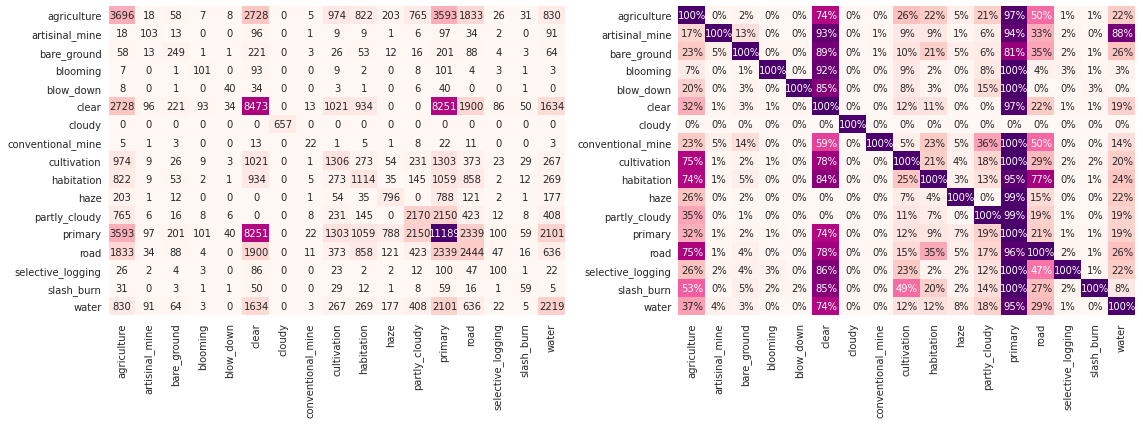

In [ ]:
#@title Labels Occurrence Matrix

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(
  co_occurrence.numpy().astype(int),
  annot=True,
  fmt='d',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)

plt.subplot(122)
sns.heatmap(
  co_occurrence_rate.numpy(),
  annot=True,
  fmt='.0%',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)
plt.tight_layout();

In [ ]:
co_occurrence = tf.transpose(p) @ p
occurrence = tf.reshape(np.diag(co_occurrence), (-1, 1))

co_occurrence_rate = tf.math.divide_no_nan(co_occurrence, occurrence)

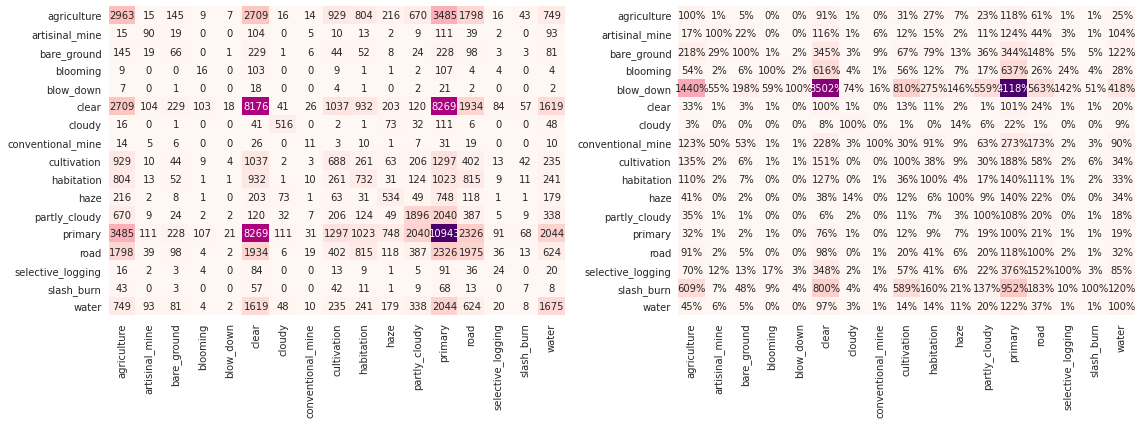

In [ ]:
#@title Predictions Relation Matrix

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(
  co_occurrence.numpy().astype(int),
  annot=True,
  fmt='d',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)

plt.subplot(122)
sns.heatmap(
  co_occurrence_rate.numpy(),
  annot=True,
  fmt='.0%',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)
plt.tight_layout();

## Generate Answers

In [ ]:
%%bash

if [ ! -f /root/tensorflow_datasets/amazon-from-space/test-jpg.tfrecords ]; then
  mkdir -p /root/tensorflow_datasets/amazon-from-space/
  cp /content/drive/MyDrive/datasets/amazon-from-space/test-jpg.tfrecords \
    /root/tensorflow_datasets/amazon-from-space/
fi

In [ ]:
test_dataset = AmazonFromSpace.load('/root/tensorflow_datasets/amazon-from-space/test-jpg.tfrecords')

In [ ]:
test = (
  test_dataset
  .map(lambda item: (item['filename'], load_fn(item)[0]), num_parallel_calls=tf.data.AUTOTUNE)
  .batch(64)
  .prefetch(Config.data.prefetch_buffer_size))

In [ ]:
def filenames_and_probs(nn, dataset):
  labels_ = []
  probs_ = []

  for ix, (files, images) in enumerate(dataset):
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    labels_.append(files)
    probs_.append(y)

    print('.', end='' if ix % 200 else '\n')
  
  return (tf.concat(labels_, axis=0),
          tf.concat(probs_, axis=0))

In [ ]:
files, preds = filenames_and_probs(nn, test)

.
........................................................................................................................................................................................................
........................................................................................................................................................................................................
........................................................................................................................................................................................................
........................................................................................................................................................................................................
............................................................................................................................................................

In [ ]:
detection_threshold = 0.5

answer = pd.DataFrame({
  'image_name': files.numpy().astype(str),
  'tags': [' '.join(AmazonFromSpace.int2str(p)) for p in (preds > detection_threshold).numpy()]
})
answer['image_name'] = answer.image_name.str.split('.').str[0]
answer.head()

,image_name,tags
0,test_17823,clear primary
1,test_29423,agriculture clear primary road
2,file_7472,agriculture clear cultivation primary
3,file_11084,clear primary
4,file_16408,agriculture clear primary road


In [ ]:
answer.to_csv(os.path.join(Config.experiment.fine_tune_logs, 'test_answer.csv'), index=False)